# MNIST 手寫數字辨識 - Softmax Regression

## 目標
* 下載並熟悉 MNIST 資料集
* 建立 tensorflow softmax regression model
* 訓練 model 並計算出準確度

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

當我們在學習一個新的程式語言的時候，譬如 `java`, `python` 之類的語言的時候，第一堂課都是學習印出 "Hello World!"．而在機器學習的領域裡面，MNIST 就有著相當於 Hello World 的地位．

而什麼是 MNIST 呢？就是一個手寫數字的資料集．它包含了一連串的手寫數字圖片，並且有相對應的數字，如下圖，看得出來就是 5, 0, 4, 1 這四個數字．

![](https://www.tensorflow.org/images/MNIST.png)

在這裡會嘗試用一個簡單的 Softmax Regression 的模型來解決這個問題，當然沒辦法達到頂尖的辨識水準，不過會是一個好的開始，接下來也會學到比較複雜但更為準確的模型，讓我們先來看看 MNIST 資料集吧．

## 下載並熟悉 MNIST data

MNIST 資料集的官網是在[Yann LeCun's website](http://yann.lecun.com/exdb/mnist/)．這裡我們只要在 python 內把以下的兩行程式碼貼上，就可以下載 MNIST 的資料集．

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


MNIST 資料集分成三個部分

1. 55,000 筆的 training data (`mnist.train`)
2. 10,000 筆的 test data (`mnist.test`)
3. 5,000 筆的 validation data (`mnist.validation`)

把資料集分成這三個部分在機器學習裡面是非常重要的，因為我們必須從學習資料以及驗證資料來看我們的學習到底有沒有效果 (generalizes)

如同上面講到的，每筆 MNIST 資料都有兩個部分，第一個是手寫的數字 image，另一個是對應的 label．在這裡我們把 image 稱作 `x`，而 label 稱作 `y`． training set 還有 test set 都有 image 以及 label．例如 training images 被稱作 `mnist.train.images`， training labels 稱作 `mnist.train.labels`．

In [3]:
# 來看看 mnist 的型態
print type(mnist)
print mnist.train.num_examples
print mnist.validation.num_examples
print mnist.test.num_examples

<class 'tensorflow.contrib.learn.python.learn.datasets.base.Datasets'>
55000
5000
10000


In [4]:
print("讓我們看一下 MNIST 訓練還有測試的資料集長得如何")
train_img = mnist.train.images
train_label = mnist.train.labels
test_img = mnist.test.images
test_label = mnist.test.labels
print
print(" train_img 的 type : %s" % (type(train_img)))
print(" train_img 的 dimension : %s" % (train_img.shape,))
print(" train_label 的 type : %s" % (type(train_label)))
print(" train_label 的 dimension : %s" % (train_label.shape,))
print(" test_img 的 type : %s" % (type(test_img)))
print(" test_img 的 dimension : %s" % (test_img.shape,))
print(" test_label 的 type : %s" % (type(test_label)))
print(" test_label 的 dimension : %s" % (test_label.shape,))

讓我們看一下 MNIST 訓練還有測試的資料集長得如何

 train_img 的 type : <type 'numpy.ndarray'>
 train_img 的 dimension : (55000, 784)
 train_label 的 type : <type 'numpy.ndarray'>
 train_label 的 dimension : (55000, 10)
 test_img 的 type : <type 'numpy.ndarray'>
 test_img 的 dimension : (10000, 784)
 test_label 的 type : <type 'numpy.ndarray'>
 test_label 的 dimension : (10000, 10)


從上面可以看到每個 image 有 784 個數字，因為每張圖片其實是 28 pixels X 28 pixels，我們可以把它看成一個很大的 array 如下圖

![](https://www.tensorflow.org/images/MNIST-Matrix.png)

把這個 array `拉平` 成一個 28x28 = 784 的向量，是用什麼方法拉平的並不重要，只要確保對於每張圖片都是用同樣的方法拉平就可以了．從這個角度來看， MNIST 就是一個 784 維向量空間裡面的點，只是有著比較複雜的[結構](http://colah.github.io/posts/2014-10-Visualizing-MNIST/)（注意，這個連結有很複雜的視覺化計算）

或許你會想問說把這個二維圖片變成一個向量，會不會造成什麼不好的效果．當然有一些更強大的電腦視覺技巧是可以學習這一些原始的數字結構的，之後我們還會看到．但在這裡我們使用的方法是 Softmax Regression ，他並不需要保留原始的數字結構，直接把它變成一個向量即可．

我們把 `mnist.train.images` 稱作一個 `tensor`（喔喔！tensorflow 的 tensor 出現了，他其實就是一個 n-dimensional array．而 tensor + flow = tensorflow，也就是指這個 n-dimensional array 變化流動的意思）這個 `tensor` 形狀為 [55000, 784]．第一個維度指的是圖片的 index，第二個則是每個圖片的 pixel 點，這個 pixel 點是一個介於 0 到 1 的值，來表示 pixel 點的強度．

![](https://www.tensorflow.org/images/mnist-train-xs.png)

而每個 MNIST 中的圖片都有一個對應的 label 也就是從 0 到 9 的數值．在這裡每個 label 都是一個 **one-hot vectors**． one-hot vector 是指說只有一個維度是 1 其他都是 0．在這裡數字 n 表示一個只有在第 n 維度（從 0 開始）數字為 1 的 10 維向量．例如 label 0 的表示法就是（[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]．因此，`mnist.train.labels` 是一個 [60000, 10] 的矩陣．

![](https://www.tensorflow.org/images/mnist-train-ys.png)

以下我們實際印出了 MNIST 的資料集來看看他長得怎麼樣

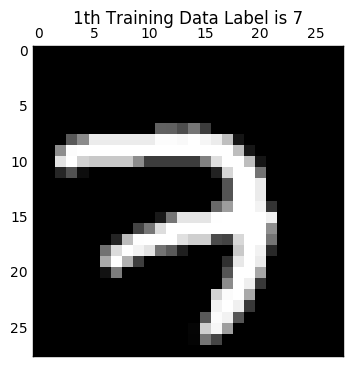

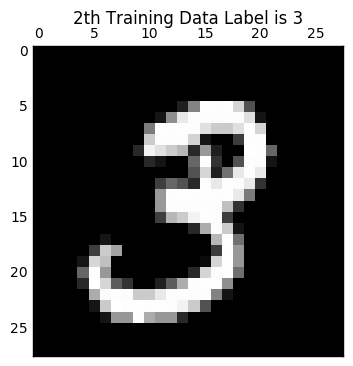

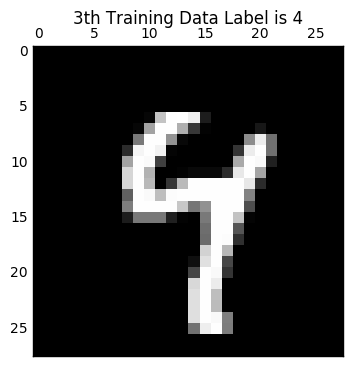

In [5]:
trainimg = mnist.train.images
trainlabel = mnist.train.labels
nsample = 1
randidx = np.random.randint(trainimg.shape[0], size=nsample)

for i in [0, 1, 2]:
    curr_img   = np.reshape(trainimg[i, :], (28, 28)) # 28 by 28 matrix 
    curr_label = np.argmax(trainlabel[i, :] ) # Label
    plt.matshow(curr_img, cmap=plt.get_cmap('gray'))
    plt.title("" + str(i + 1) + "th Training Data " 
              + "Label is " + str(curr_label))

## Softmax Regressions

In [6]:
import tensorflow as tf
x = tf.placeholder(tf.float32, [None, 784])
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))
y = tf.nn.softmax(tf.matmul(x, W) + b)
print y

Tensor("Softmax:0", shape=(?, 10), dtype=float32)
